In [1]:
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.solve import solve
from pysme.abund import Abund
from pysme import sme as SME
from pysme import util

from pysme.synthesize import synthesize_spectrum
from astropy.constants import c
from pysme.util import vac2air

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import sys
import os

warnings.filterwarnings('ignore')

In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [4]:
os.environ['NUMEXPR_MAX_THREADS'] = '80' #change this number using the correct number of cores/threads in jupyter.slurm

In [5]:
#Prepare catalogue ingestion

In [6]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe.csv')

In [7]:
uves.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,sme_fe_vrad3,fe_nlte,efe_nlte_sme,efe_nlte_fit,vmac_nlte,evmac_nlte_sme,evmac_nlte_fit,sme_nlte_vrad1,sme_nlte_vrad2,sme_nlte_vrad3
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,-0.160502,7.502974,0.253366,0.005697,5.270773,5.138584,0.091985,0.085946,0.066876,-0.149777
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,-0.151334,7.515217,0.244008,0.004638,4.753303,5.172595,0.079677,0.068610,0.068886,-0.103765


In [8]:
#pysme that only need to be executed once
# linelist_short_all = ValdFile('linelist/3800-6800_short.lin')
linelist = ValdFile('linelist/VALD_korg_linelist_3000_9000.lin', medium='air')
linelist.wlcent = vac2air(linelist.wlcent, 'A')

print('Number of lines in the linelist: %d' %linelist.species.size)

delta_H_line = 10. #AA
delta_line = 0.75 #AA
wl_G_band = 4300 #AA
delta_G_band = 40. #AA

wl_Halpha_line = 6562.79 #AA
delta_Halpha = 1.0 #AA
wl_Hbeta_line = 4861.35 #AA
delta_Hbeta = 0.75 #AA

[2024-11-14 11:27:26,273] [INFO] [vald:loads:173]: Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin


INFO - Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin


[2024-11-14 11:27:27,797] [WARNING] [vald:parse_references:530]: Could not find citation key: FBHM
[2024-11-14 11:27:27,799] [DEBUG] [vald:parse_references:531]: 'fbhm'


WARNING - Could not find citation key: FBHM
Number of lines in the linelist: 41861


In [9]:
wmin_blue = 4200
wmax_blue = 4350

In [10]:
linelist = linelist[(linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue)]

In [11]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O'] = abund['O'] + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S'] = abund['S'] + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [12]:
elems_to_include = ['C 1', 'C2 1', 'CH 1', 'CN 1']

In [13]:
mask_cont = pd.read_csv('continuum_model/sme_cont_mask_blue', delim_whitespace=True, names=['wl', 'mask_values'])

In [14]:
#SME parallel and limits functions

In [15]:
def limits(species = 'C', species_to_keep = [], spec_id = '', sme_file = '', wlmin = 0, wlmax = 0, start = -2.0, stop = 2.0, step = 0.25):
    
    # plt.figure(figsize=(7,7), dpi=100)
    
    util.start_logging('logs/elems_limits.dat', level='WARNING')
    species = 'C'
    limit = solar.abund.get_element('%s' %species)
    # start, stop, step = -2.0, 2.0, 0.25

    for delta_abund in np.linspace(start, stop, int((stop - start) / step + 1)):

        synth = SME_Structure.load(sme_file)
        # if delta_abund == start: print(synth.abund.get_element('C'))
        # if delta_abund == start: plt.step(synth.wave.data, synth.synth.data, lw=1, color='r')
        synth.linelist = linelist[(linelist.wlcent > wlmin) & (linelist.wlcent < wlmax)]

        f_wl_limit = (synth.wave.data > wlmin) & (synth.wave.data < wlmax)

        for elem in synth.abund.pattern.keys():
            if (elem == 'H') or (elem == 'He'):
                continue
            if elem in species_to_keep:
                continue
            synth.abund.update_pattern({elem:0.0})
        synth.abund.update_pattern({'%s' %species: solar.abund.get_element('%s' %species) + delta_abund})
        # print('%s' %species, solar.abund.get_element('%s' %species) + delta_abund)

        synth.vrad_flag = 'None'
        synth.cscale_flag = 'None'
        synth = synthesize_spectrum(synth)
        # synth_data = synth.synth.data

        mean_synth = np.percentile(synth.synth.data[f_wl_limit], 10)
        std_spec = np.std(synth.spec.data[f_wl_limit])
        
        # if delta_abund == start: plt.step(synth.wave.data, synth.spec.data, lw=1, color='k')
        # if delta_abund == start: plt.hlines(1.-std_spec, wlmin, wlmax, color='b', lw=1, ls='--')
        # plt.step(synth.wave.data, synth.synth.data, lw=1, color='g', alpha=0.2)
        # plt.hlines(mean_synth, wlmin, wlmax, color='r', lw=1, ls='--', alpha=0.3)
        # plt.xlim(wlmin, wlmax)

        #If mean synth flux is more (bigger depth) that std: you are in outside limit regime
        #linspace in the starst is fliped to ascend in abundance space
        if mean_synth < (1. - std_spec):
            limit = solar.abund.get_element('%s' %species) + delta_abund - step/2.
            # plt.show()
            return limit
        else:
            continue
    # plt.show()
    return limit

In [16]:
def sme_parallel(i, input_row, tol=1e-8):
    
    #Create SME structures
    sme = SME_Structure()

    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = 42000, 'gauss', True, True

    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol    
    sme.vrad_bounds = -5., 5.

    sme.cscale_flag = 'constant'
    # sme.cscale = 1.0
    sme.cscale_type = 'mask' #'mcmc'
    sme.fitresults.maxiter = 50

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/cfe_run.txt', level='ERROR')

    #Reading norm specta from files
    blue_spec = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
    blue_spec.waveobs = blue_spec.waveobs * 10.

    sme.wave = blue_spec.waveobs[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)]
    sme.spec = blue_spec.flux[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)]
    sme.uncs = blue_spec.err[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)]
    del blue_spec

    #Masking process to derive Teff, logg, monh and vmic (vmac if needed)
    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = mask_cont.mask_values.values[(mask_cont.wl.values > wmin_blue) & (mask_cont.wl.values < wmax_blue)] 
    ll_mask = np.zeros(linelist.species.size).astype(bool)

    for wline, mask_species in linelist[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1

            ll_mask[(linelist.wlcent > wline-delta_line) & (linelist.wlcent < wline+delta_line)] = True
            continue
    del idx_

    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist[ll_mask]
    del ll_mask

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = 'whole'

    #input guesses from SME
    sme.teff = input_row.teff
    sme.logg = input_row.logg
    sme.monh = input_row.monh
    sme.vmic = input_row.vmic
    sme.vmac = input_row.vmac_fe
    sme.vrad = input_row.sme_fe_vrad1

    sme.abund.update_pattern({'Fe':uves.fe.values[i]})
    sme.abund.update_pattern({'C':solar.abund.get_element('C') + sme.monh})
    
    #NLTE grids
    # sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
    # sme.nlte.set_nlte('C', 'nlte_C_ama51_pysme.grd')

    fitparameters = ['abund C']
    #Do the heavy lifting
    sme = solve(sme, fitparameters)

    c, ec_sme, ec_fit, niter_c = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0], sme.fitresults.iterations

    #Bad C cases:
    if (c > 10.) | (c < 4.) | (niter_c == 1.):

        sme.abund.update_pattern({'C':solar.abund.get_element('C')})
        sme.cscale = 1.0
        
        sme.accxt, sme.accgt, sme.accft = 1e-10, 1e-10, 1e-10
        sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = 1e-10, 1e-10, 1e-10
        sme.accwi, sme.accrt, sme.clim, sme.chirat = 1e-10, 1e-10, 1e-10, 1e-10   

        sme = solve(sme, fitparameters)
        c, ec_sme, ec_fit, niter_c = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0], sme.fitresults.iterations

    sme.save('sme_save/UVES_cfe_%s' %input_row.spec_id)
    del sme
    
    #Limits: checking
    is_limit = (c < 7.0) | (c > 10.) | (niter_c == 1.)
    if is_limit:
        c = limits('C', [], input_row.spec_id, 'sme_save/UVES_cfe_%s.sme' %input_row.spec_id, wlmin=4309, wlmax=4316)

    data_to_write = np.vstack((input_row.spec_id, c, ec_sme, ec_fit, is_limit, niter_c)).T

    columns_c = ['spec_id', 'c', 'ec_sme', 'ec_fit', 'is_limit_c', 'niter_c']
    columns_c_nlte = ['spec_id', 'c_nlte', 'ec_nlte_sme', 'ec_nlte_fit', 'is_limit_c_nlte', 'niter_c_nlte']
    pd.DataFrame(data=data_to_write, columns=columns_c).to_csv('tmp_carbon/UVES_cfe_%s.csv' %input_row.spec_id, index=False, header=False)
    del data_to_write

    return

In [74]:
%%time
#Parallel execution
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe.csv')
Parallel(n_jobs=-1, verbose=1)(delayed(sme_parallel)(i, input_row, tol=1e-9) for i, input_row in uves.iterrows())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[2024-11-01 12:24:21,180] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:565: Warning: WARNING: EOS-computed electron density differs from the model by 77% in layer 1
  dll.Ionization(0)

[2024-11-01 12:24:55,037] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:565: Warning: WARNING: EOS-computed electron density differs from the model by 77% in layer 1
  dll.Ionization(0)

[2024-11-01 12:25:28,892] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/pysme/synthesize.py:565: Warning: WARNING: EOS-computed electron density differs from the model by 77% in layer 1
  dll.Ionization(0)

[2024-11-01 12:26:03,346] [WARNING] [warnings:_showwarnmsg:109]: /misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/py

CPU times: user 1.24 s, sys: 941 ms, total: 2.18 s
Wall time: 1h 36min 11s


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 96.2min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
#Merge all files

In [75]:
os.system('cat tmp_carbon/UVES_cfe_* > tmp_merged/UVES_cfe.csv');

In [76]:
!head tmp_merged/UVES_cfe.csv -n 2

1166634514845213568_3572891_000,8.35030447957724,0.15862997591953204,0.005420913953677479,False,13
1172165023972931072_3573727_087,8.342535202409852,0.16428165154156532,0.007953275368053424,False,13


In [77]:
# 'spec_id', 'c', 'ec_sme', 'ec_fit', 'is_limit_c', 'niter_c'
!sed -i '1i \spec_id,c,ec_sme,ec_fit,is_limit_c,niter_c' tmp_merged/UVES_cfe.csv

In [78]:
# %%time
# sme = sme_parallel(0, uves.iloc[0], tol=1e-4)

In [17]:
#Retrieve carbon corrections from Placco:

In [35]:
cfe = pd.read_csv('tmp_merged/UVES_cfe.csv')
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe.csv')
uves = uves.merge(right=cfe, on='spec_id')

In [19]:
from selenium.webdriver.firefox.options import Options
from seleniumrequests import Firefox
import time

In [20]:
firefox_options = Options()
firefox_options.add_argument("--headless")
firefox_options.add_argument("--no-sandbox")
firefox_options.add_argument("--disable-dev-shm-usage")
firefox_options.set_preference("dom.forms.number", False)

In [26]:
def Placco_parallel(i, input_row):
    feh = np.round(input_row.fe + input_row.monh - solar.abund.get_element('Fe'), 2)
    cfe = np.round(input_row.c - solar.abund.get_element('C'), 2)
    lgg = input_row.logg - 0.5
    ff = Firefox(options=firefox_options)
    response = ff.request('POST', 'https://vplacco.pythonanywhere.com/', data={'lgg':lgg, 'feh':feh, 'cfe':cfe})
    carbon_correction = float(response.text.split('The [C/Fe] correction is: ')[1].split(' ([N/Fe]=0.0 case)')[0])
    ff.quit()

    data_to_write = np.vstack((input_row.spec_id, carbon_correction)).T
    pd.DataFrame(data=data_to_write, columns=['spec_id', 'carbon_correction']).to_csv('tmp_carbon/UVES_carbon_corrections_logg_05.csv', index=False, header=False, mode='a')
    time.sleep(np.random.randint(low=10, high=20))

    return

In [27]:
# if os.path.exists('tmp_carbon/UVES_carbon_corrections.csv'): os.system('rm tmp_carbon/UVES_carbon_corrections.csv')
# if os.path.exists('tmp_carbon/UVES_carbon_corrections_logg_03.csv'): os.system('rm tmp_carbon/UVES_carbon_corrections_logg_03.csv')
# if os.path.exists('tmp_carbon/UVES_carbon_corrections_logg_05.csv'): os.system('rm tmp_carbon/UVES_carbon_corrections_logg_05.csv')
Parallel(n_jobs=5, verbose=5)(delayed(Placco_parallel)(i, input_row) for i, input_row in uves.iterrows());

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   30.3s


SessionNotCreatedException: Message: Session is already started


In [28]:
# !sed -i '1i \spec_id,carbon_correction' tmp_carbon/UVES_carbon_corrections_logg.csv
!sed -i '1i \spec_id,carbon_correction_03' tmp_carbon/UVES_carbon_corrections_logg_03.csv
# !sed -i '1i \spec_id,carbon_correction_05' tmp_carbon/UVES_carbon_corrections_logg_05.csv

In [36]:
carbon_correction = pd.read_csv('tmp_carbon/UVES_carbon_corrections_logg_03.csv')

In [37]:
uves = uves.merge(right=carbon_correction, on='spec_id')

In [38]:
uves.to_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr.csv', index=False, header=True)

In [57]:
#Plotting to check carbon and corrections

In [39]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr.csv')

In [40]:
# uves_cfe.rename(columns={'ec_sme':'ec'}, inplace=True)
# uves_cfe_extra.rename(columns={'ec_sme':'ec'}, inplace=True)

In [41]:
# uves_cfe = uves_cfe.drop(columns=['ec_fit'])
# uves_cfe_extra = uves_cfe_extra.drop(columns=['ec_fit'])

In [42]:
uves.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,evmac_nlte_fit,sme_nlte_vrad1,sme_nlte_vrad2,sme_nlte_vrad3,c,ec_sme,ec_fit,is_limit_c,niter_c,carbon_correction_03
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,0.091985,0.085946,0.066876,-0.149777,8.350304,0.158630,0.005421,False,13,0.45
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,0.079677,0.068610,0.068886,-0.103765,8.342535,0.164282,0.007953,False,13,0.19


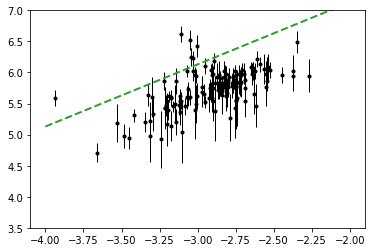

In [85]:
f_ec = (uves.ec_sme.values < 0.5)

plt.scatter(uves.fe.values[f_ec] + uves.monh.values[f_ec] - solar.abund.get_element('Fe'), uves.c.values[f_ec] + uves.monh.values[f_ec] + uves.carbon_correction_03.values[f_ec], color='k', s=5)
plt.errorbar(uves.fe.values[f_ec] + uves.monh.values[f_ec] - solar.abund.get_element('Fe'), uves.c.values[f_ec] + uves.monh.values[f_ec] + uves.carbon_correction_03.values[f_ec], 
            fmt='k.', yerr=uves.ec_sme.values[f_ec], lw=1)
x = np.linspace(-4, -2)
plt.plot(x, solar.abund.get_element('C') + x + 0.7, ls='--', color='C2', label='[C/Fe] = 0.7', lw=2)

plt.ylim(3.5, 7)
plt.show()

In [69]:
uves.spec_id[np.argmin(uves.fe.values[f_ec] + uves.monh.values[f_ec] - solar.abund.get_element('Fe'))]

'6167441439259305088_3573234_046'

'0.35'

In [28]:
# uves_cfe0.to_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon.csv', index=False, header=True)
# uves_cfe.to_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon.csv', index=False, header=True)

In [29]:
# pd.options.display.float_format = '{:,.2f}'.format

In [30]:
# uves_cfe['cfe'] = uves_cfe.c.values - solar.abund.get_element('C')
# uves_cfe[['logg', 'monh', 'cfe']].to_csv('Carbon_correction_Placco.csv', index=False, header=True, mode='w')

In [31]:
# carbon = np.loadtxt('Carbon_correction_Placco.csv', skiprows=1, delimiter=',')
# np.savetxt('Carbon_correction_Placco.csv', carbon, fmt='%2.3f', delimiter=',')

In [107]:
#Read Carbon file

In [32]:
# uves_cfe = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon.csv')

In [119]:
# uves_cfe.drop(columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)

In [122]:
# bad_c = uves_cfe.query("(ec > 1.2) | (c < 7.0)")

In [121]:
# bad_c.spec_id.values[1]

In [33]:
# %%time
# sme = sme_parallel(0, bad_c.iloc[0])

In [34]:
# %%time

# #Single execution
# Parallel(n_jobs=-1, verbose=0)(delayed(sme_parallel)(i, input_row, tol=5e-9) for i, input_row in bad_c.iterrows())

# # j = 0
# # os.system('cat tmp_carbon/mcmc_cfe_* > tmp_merged/mcmc_cfe_%d.csv' %j);
# # spec_id,cfe,ecfe_sme,cfe_fit

In [35]:
# os.system('cat tmp_carbon/cfe_* > tmp_merged/cfe.csv');
# !sed -i '1i \spec_id,c,ec_sme,ec_fit' tmp_merged/cfe*

In [123]:
#Limits

In [124]:
def limits(species = 'C', species_to_keep = [], spec_id = '', sme_file = '', wlmin = 0, wlmax = 0, start = -2.0, stop = 2.0, step = 0.25):
    
    # plt.figure(figsize=(7,7), dpi=100)
    
    util.start_logging('logs/elems_limits.dat', level='WARNING')
    species = 'C'
    limit = solar.abund.get_element('%s' %species)
    # start, stop, step = -2.0, 2.0, 0.25

    for delta_abund in np.linspace(start, stop, int((stop - start) / step + 1)):

        synth = SME_Structure.load(sme_file)
        # if delta_abund == start: print(synth.abund.get_element('C'))
        # if delta_abund == start: plt.step(synth.wave.data, synth.synth.data, lw=1, color='r')
        synth.linelist = linelist_short_all[(linelist_short_all.wlcent > wlmin) & (linelist_short_all.wlcent < wlmax)]

        f_wl_limit = (synth.wave.data > wlmin) & (synth.wave.data < wlmax)

        for elem in synth.abund.pattern.keys():
            if (elem == 'H') or (elem == 'He'):
                continue
            if elem in species_to_keep:
                continue
            synth.abund.update_pattern({elem:0.0})
        synth.abund.update_pattern({'%s' %species: solar.abund.get_element('%s' %species) + delta_abund})
        # print('%s' %species, solar.abund.get_element('%s' %species) + delta_abund)

        synth.vrad_flag = 'None'
        synth.cscale_flag = 'None'
        synth = synthesize_spectrum(synth)
        # synth_data = synth.synth.data

        mean_synth = np.percentile(synth.synth.data[f_wl_limit], 10)
        std_spec = np.std(synth.spec.data[f_wl_limit])
        
        # if delta_abund == start: plt.step(synth.wave.data, synth.spec.data, lw=1, color='k')
        # if delta_abund == start: plt.hlines(1.-std_spec, wlmin, wlmax, color='b', lw=1, ls='--')
        # plt.step(synth.wave.data, synth.synth.data, lw=1, color='g', alpha=0.2)
        # plt.hlines(mean_synth, wlmin, wlmax, color='r', lw=1, ls='--', alpha=0.3)
        # plt.xlim(wlmin, wlmax)

        #If mean synth flux is more (bigger depth) that std: you are in outside limit regime
        #linspace in the starst is fliped to ascend in abundance space
        if mean_synth < (1. - std_spec):
            limit = solar.abund.get_element('%s' %species) + delta_abund - step/2.
            # plt.show()
            return limit
        else:
            continue
    # plt.show()
    return limit

In [125]:
is_limit = np.zeros_like(uves_cfe.c.values).astype(bool)
abund_limit = uves_cfe.c.values

In [126]:
is_limit[(uves_cfe.ec.values > 1.0) | (uves_cfe.c.values < 7.0)] = True

In [127]:
%%time

for i, limit in enumerate(is_limit):
    if limit:
        abund_limit[i] = limits('C', [], uves_cfe.spec_id.values[i], 'sme_save/cfe_%s.sme' %uves_cfe.spec_id.values[i], wlmin=4309, wlmax=4315)

CPU times: user 1min 26s, sys: 277 ms, total: 1min 27s
Wall time: 1min 27s


In [128]:
uves_cfe['is_limit_c'] = is_limit
uves_cfe['limit_c'] = abund_limit

In [129]:
uves_cfe.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,emonh,vmic,evmic,vmac,evmac,c,ec,ec_fit,is_limit_c,limit_c
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,0.131525,2.104566,0.078616,5.115226,0.110029,8.464024,0.149136,0.004981,False,8.464024
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,0.026559,2.226055,0.089651,4.785015,0.274269,8.414520,0.139613,0.005474,False,8.414520


In [130]:
uves_cfe.to_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_limits.csv')

In [83]:
uves_cfe.query("is_limit_c == True").spec_id

9      2569615268897126016_3708424_127
62     4854289415101796608_3708430_135
64     4905666294932720000_3708505_125
66     4954240794503614720_3704133_132
76     6107795579151078528_3573219_042
96     6445544385605809152_3573258_043
106    6523938984849548032_3573742_119
138    6767541317898238976_3572828_022
139    6776164134760319488_3576358_062
150    6859555838257273600_3573691_106
151    6859555838257273600_3573691_115
Name: spec_id, dtype: object

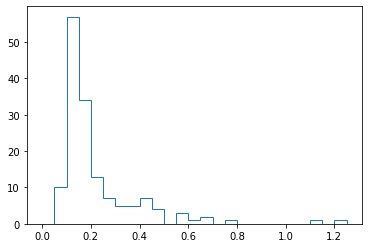

In [99]:
# plt.hist(uves_cfe0.cfe.values, bins=25, histtype='step')
plt.hist(uves_cfe.ec.values, bins=25, histtype='step', range=(0, 1.25))
# plt.hist(uves_cfe2.cfe.values, bins=25, histtype='step')
plt.show()

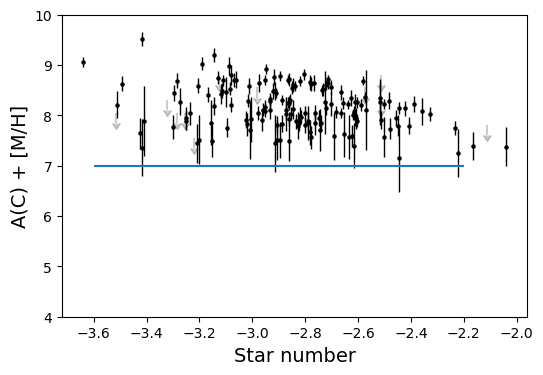

In [104]:
plt.figure(dpi=100)
plt.scatter(uves_cfe.monh.values[~is_limit], uves_cfe.c.values[~is_limit], s=5, color='k')
plt.errorbar(uves_cfe.monh.values[~is_limit], uves_cfe.c.values[~is_limit], fmt='k.', yerr=uves_cfe.ec.values[~is_limit], ms=0.5, lw=1)

plt.errorbar(uves_cfe.monh[is_limit], abund_limit[is_limit], fmt='.', yerr=0.2 * np.ones_like(uves_cfe.ec.values[is_limit]), ms=0.1, uplims=is_limit[is_limit], color='k', alpha=0.2)

# x = np.linspace(-4, -2)
# plt.plot(x, solar.abund.get_element('C') + x + 0.7, ls='--', color='C2', label='[C/Fe] = 0.7', lw=2)

plt.hlines(7.0, -3.6, -2.2)
plt.ylim(4, 10)
# plt.ylim(-0.5,35)
plt.xlabel('Star number', size=14)
plt.ylabel('A(C) + [M/H]', size=14)
plt.show()

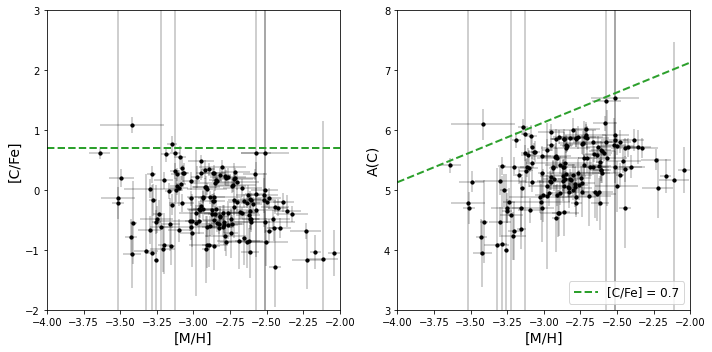

In [64]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(uves_cfe.monh.values, uves_cfe.c.values - solar.abund.get_element('C'), s=10, color='k', zorder=9)
plt.errorbar(uves_cfe.monh.values, uves_cfe.c.values - solar.abund.get_element('C'), xerr=uves_cfe.emonh.values, yerr=uves_cfe.ec.values, fmt='k.', color='k', alpha=0.25)

plt.hlines(0.7, -4, -2, ls='--', color='C2', lw=2)
# plt.hlines(1.0, -4, -2, ls=':', color='C2')

plt.xlabel('[M/H]', size=14)
plt.ylabel('[C/Fe]', size=14)
plt.xlim(-4, -2)
plt.ylim(-2, 3.0)

plt.subplot(1,2,2)
plt.scatter(uves_cfe.monh.values, uves_cfe.c.values + uves_cfe.monh.values, s=10, color='k', zorder=9, label='_nolegend_')
plt.errorbar(uves_cfe.monh.values, uves_cfe.c.values + uves_cfe.monh.values, xerr=uves_cfe.emonh.values, 
             yerr=(uves_cfe.ec.values**2. + uves_cfe.emonh.values**2.)**0.5, fmt='k.', color='k', alpha=0.25, label='_nolegend_')

x = np.linspace(-4, -2)
plt.plot(x, solar.abund.get_element('C') + x + 0.7, ls='--', color='C2', label='[C/Fe] = 0.7', lw=2)
# plt.plot(x, solar.abund.get_element('C') + x + 1.0, ls=':', color='C2', label='[C/Fe] = 1.0')

plt.legend(loc='lower right', fontsize=12)

plt.xlabel('[M/H]', size=14)
plt.ylabel('A(C)', size=14)
plt.xlim(-4, -2)
plt.ylim(3, 8)

plt.tight_layout()
plt.show()

In [38]:
jina = pd.read_csv('JINA/JINAbase_2021_nolims.csv')

carbon_corrections = pd.read_csv('Carbon_corrections.csv')

solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

In [39]:
uves_cfe['cfe'] = uves_cfe.c.values - solar.abund.get_element('C')
uves_cfe['carbon_corr'] = carbon_corrections.cor.values

In [40]:
jina['feh'] = jina.Fe.values - solar.abund.get_element('Fe')
jina['cfe'] = (jina.C.values - solar.abund.get_element('C')) - (jina.Fe.values - solar.abund.get_element('Fe'))

In [41]:
f_carbon = (uves_cfe.cfe.values > -2.)
uves_cfe = uves_cfe[f_carbon]

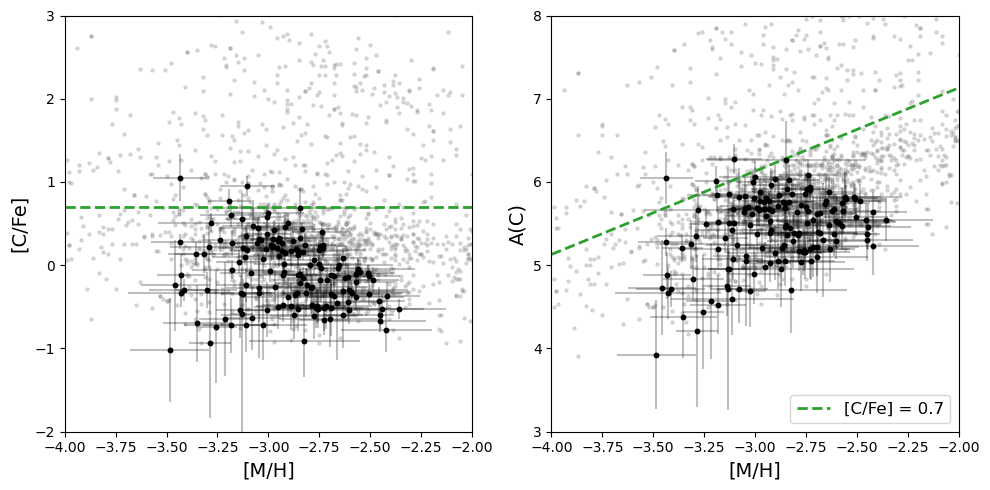

In [44]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(uves_cfe.monh.values, uves_cfe.cfe.values , s=10, color='k', zorder=9)
plt.errorbar(uves_cfe.monh.values, uves_cfe.cfe.values , xerr=uves_cfe.emonh.values, yerr=uves_cfe.ec.values, fmt='k.', color='k', alpha=0.25)
plt.scatter(jina.feh.values, jina.cfe.values, s=5, color='grey', alpha=0.25)

plt.hlines(0.7, -4, -2, ls='--', color='C2', lw=2)
# plt.hlines(1.0, -4, -2, ls=':', color='C2')

plt.xlabel('[M/H]', size=14)
plt.ylabel('[C/Fe]', size=14)
plt.xlim(-4, -2)
plt.ylim(-2, 3.0)

plt.subplot(1,2,2)
plt.scatter(uves_cfe.monh.values, uves_cfe.c.values  + uves_cfe.monh.values, s=10, color='k', zorder=9, label='_nolegend_')
plt.errorbar(uves_cfe.monh.values, uves_cfe.c.values  + uves_cfe.monh.values, xerr=uves_cfe.emonh.values, 
             yerr=(uves_cfe.ec.values**2. + uves_cfe.emonh.values**2.)**0.5, fmt='k.', color='k', alpha=0.25, label='_nolegend_')

plt.scatter(jina.feh.values, jina.C.values, s=5, color='grey', alpha=0.25, label='_nolegend_')

x = np.linspace(-4, -2)
plt.plot(x, solar.abund.get_element('C') + x + 0.7, ls='--', color='C2', label='[C/Fe] = 0.7', lw=2)
# plt.plot(x, solar.abund.get_element('C') + x + 1.0, ls=':', color='C2', label='[C/Fe] = 1.0')

plt.legend(loc='lower right', fontsize=12)

plt.xlabel('[M/H]', size=14)
plt.ylabel('A(C)', size=14)
plt.xlim(-4, -2)
plt.ylim(3, 8)

plt.tight_layout()
plt.savefig('plots/UVES_carbon.pdf', dpi=300)
plt.show()

In [43]:
n_cemp = np.sum(uves_cfe.cfe.values + uves_cfe.carbon_corr.values > 0.7)
n_tot = uves_cfe.ra.size

print('Total number of UVES stars: %d, and %d (%d%%) CMEP with [C/Fe] > 0.7' %(n_tot, n_cemp, 100*n_cemp/n_tot))

Total number of UVES stars: 153, and 12 (7%) CMEP with [C/Fe] > 0.7


In [45]:
print(uves_cfe.spec_id.values[(uves_cfe.c.values > 9.0)], 
uves_cfe.c.values[(uves_cfe.c.values > 9.0)])

['3598383734427539840_3576364_061' '6167441439259305088_3573234_046'
 '6425379106130933376_3573700_088'] [9.02782073 9.19649213 9.51631897]


In [ ]:
#Read complete file

In [40]:
uves.query("spec_id == '6167441439259305088_3573234_046'")

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,teff,eteff,logg,elogg,monh,emonh,vmic,evmic,vmac,evmac
83,6167441439259305088,0.061413,11.966476,0.002767,12.400405,0.002961,11.354571,0.0038,13.373514,0.008205,...,4842.658431,62.388589,1.619493,0.057071,-3.143767,0.033567,2.338611,0.124232,6.161349,0.20273


In [17]:
sme = SME_Structure.load('sme_save/UVES_cfe_6167441439259305088_3573234_046.sme')

[2024-11-14 11:27:30,898] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_cfe_6167441439259305088_3573234_046.sme


INFO - Loading SME file sme_save/UVES_cfe_6167441439259305088_3573234_046.sme


In [18]:
# spec_id = '2541284393302759296_3708442_129'

In [19]:
# sme.linelist = linelist_short_all
# sme.abund.update_pattern({'C':9.4})
# # sme.vmac = 5.
# sme = synthesize_spectrum(sme);

In [38]:
sme_p100k = SME_Structure.load('sme_save/UVES_cfe_6167441439259305088_3573234_046.sme')
sme_p100k.teff = sme_p100k.teff + 200.
sme_p100k.vrad_flag = 'None'
sme_p100k.cscale_flag = 'None'
sme_p100k = synthesize_spectrum(sme_p100k)

sme_m100k = SME_Structure.load('sme_save/UVES_cfe_6167441439259305088_3573234_046.sme')
sme_m100k.teff = sme_m100k.teff - 200.
sme_m100k.vrad_flag = 'None'
sme_m100k.cscale_flag = 'None'
sme_m100k = synthesize_spectrum(sme_m100k)

[2024-11-14 11:47:53,869] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_cfe_6167441439259305088_3573234_046.sme
[2024-11-14 11:47:53,896] [INFO] [config:__init__:28]: No cconfiguration file found at /misc/store/home_zztop/fgran/.sme/config.json, using default values instead
[2024-11-14 11:47:53,898] [INFO] [synthesize:__init__:48]: Don't forget to cite your sources. Use sme.citation()
[2024-11-14 11:47:53,899] [DEBUG] [synthesize:synthesize_spectrum:511]: Synthesize spectrum
[2024-11-14 11:47:53,899] [DEBUG] [synthesize:synthesize_spectrum:512]: SME_Structure(citation_info='\n            @ARTICLE{2017A&A...597A..16P,\n                author = {{Piskunov}, Nikolai and {Valenti}, Jeff A.},\n                title = "{Spectroscopy Made Easy: Evolution}",\n                journal = {\\aap},\n                keywords = {stars: abundances, radiative transfer, stars: fundamental parameters, stars: atmospheres, techniques: spectroscopic, Astrophysics - Instrumentation and Methods for As

INFO - Loading SME file sme_save/UVES_cfe_6167441439259305088_3573234_046.sme
INFO - No cconfiguration file found at /misc/store/home_zztop/fgran/.sme/config.json, using default values instead
INFO - Don't forget to cite your sources. Use sme.citation()


[2024-11-14 11:47:54,164] [DEBUG] [synthesize:synthesize_segment:695]: Segment 0 out of 1
[2024-11-14 11:48:51,819] [DEBUG] [synthesize:synthesize_segment:730]: Integrate specific intensities
[2024-11-14 11:48:57,165] [DEBUG] [synthesize:synthesize_segment:749]: Apply detector broadening
[2024-11-14 11:48:57,205] [DEBUG] [synthesize:synthesize_spectrum:605]: Radial velocity: [0.]
[2024-11-14 11:48:57,206] [DEBUG] [synthesize:synthesize_spectrum:606]: Continuum coefficients: [[1.]]
[2024-11-14 11:48:57,207] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_cfe_6167441439259305088_3573234_046.sme
[2024-11-14 11:48:57,234] [INFO] [config:__init__:28]: No cconfiguration file found at /misc/store/home_zztop/fgran/.sme/config.json, using default values instead
[2024-11-14 11:48:57,236] [INFO] [synthesize:__init__:48]: Don't forget to cite your sources. Use sme.citation()
[2024-11-14 11:48:57,237] [DEBUG] [synthesize:synthesize_spectrum:511]: Synthesize spectrum
[2024-11-14 11:48:57,237] 

INFO - Loading SME file sme_save/UVES_cfe_6167441439259305088_3573234_046.sme
INFO - No cconfiguration file found at /misc/store/home_zztop/fgran/.sme/config.json, using default values instead
INFO - Don't forget to cite your sources. Use sme.citation()


[2024-11-14 11:48:57,523] [DEBUG] [synthesize:synthesize_segment:695]: Segment 0 out of 1
[2024-11-14 11:50:04,005] [DEBUG] [synthesize:synthesize_segment:730]: Integrate specific intensities
[2024-11-14 11:50:09,362] [DEBUG] [synthesize:synthesize_segment:749]: Apply detector broadening
[2024-11-14 11:50:09,402] [DEBUG] [synthesize:synthesize_spectrum:605]: Radial velocity: [0.]
[2024-11-14 11:50:09,403] [DEBUG] [synthesize:synthesize_spectrum:606]: Continuum coefficients: [[1.]]


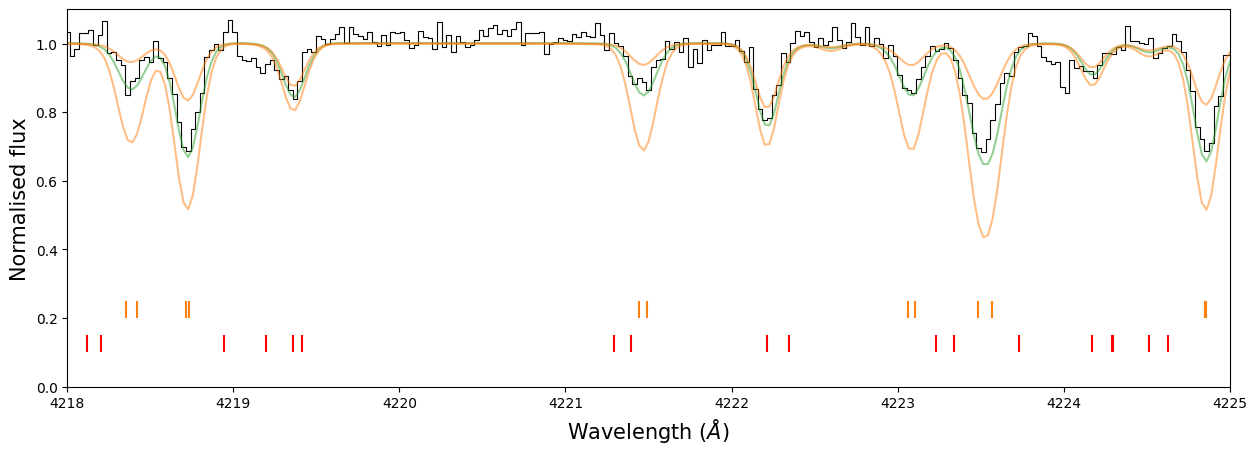

In [39]:
plt.figure(figsize=(15,5), dpi=100)

plt.step(sme.wave.data, sme.spec.data, lw=0.8, color='k', alpha=0.99, where='mid')
plt.plot(sme.wave.data, sme.synth.data, lw=1.5, color='C2', alpha=0.5)

plt.plot(sme_p100k.wave.data, sme_p100k.synth.data, lw=1.5, color='C1', alpha=0.5)
plt.plot(sme_m100k.wave.data, sme_m100k.synth.data, lw=1.5, color='C1', alpha=0.5)


# plt.scatter(sme.wave.data[sme.mask.data == 2], sme.mask.data[sme.mask.data == 2]-1, color='grey', alpha=0.1)
# plt.scatter(sme.wave.data, sme.mask.data, color='C4', alpha=0.1)

for wline, species, depth in pd.DataFrame(sme.linelist)[['wlcent', 'species', 'depth']].values:#linelist_short_all[['wlcent', 'species', 'depth']]:
    # if 'H 1' in species:
    #     continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
    if (species == 'CN 1'):
        plt.vlines(wline, 0.05, 0.15, color='b')
    if species not in elems_to_include:
        continue
#     # if (depth > 0.85) | (depth < 0.15):
#     #     continue
    plt.vlines(wline, 0.2, 0.25, color='C1')
    # plt.annotate(text='%s' %species, xy=(wline, 0.05), rotation=90)

# plt.xlim(4280, 4312)
# plt.xlim(4250, 4325)
# plt.xlim(4270, 4317)
# plt.xlim(4250, 4275)
# plt.xlim(4300, 4320)
plt.xlim(4218, 4225)
plt.ylim(0.0, 1.1)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)
# plt.xlim(6500, 6600)
# plt.savefig('plots/CEMP2.pdf')
plt.show()

In [74]:
sme.fitresults.values, sme.fitresults.uncertainties, sme.fitresults.iterations

(array([9.14830418]), array([0.12852364]), 7)

In [20]:
sme.teff

4870.840554500451

In [30]:
# ll = pd.DataFrame(linelist_short_all)

In [31]:
# ll.query("species == 'CH 1'")
# np.unique(np.ravel(linelist_short_all[['species']]))

In [32]:
# plt.hist(ll.query("species == 'CH 1'").wlcent, bins=100)
# plt.show()

In [27]:
sme.linelist = linelist_short_all

In [28]:
# sme.abund.update_pattern({'C':7.8})
# sme.abund.update_pattern({'Ba':2.1})

In [29]:
%%time
sme = synthesize_spectrum(sme)

[2024-02-21 15:34:05,482] [INFO] [synthesize:__init__:48]: Don't forget to cite your sources. Use sme.citation()


INFO - Don't forget to cite your sources. Use sme.citation()
CPU times: user 5.66 s, sys: 12 ms, total: 5.68 s
Wall time: 5.67 s


In [30]:
elems_to_include

['C 1', 'C2 1', 'CH 1', 'CN 1']

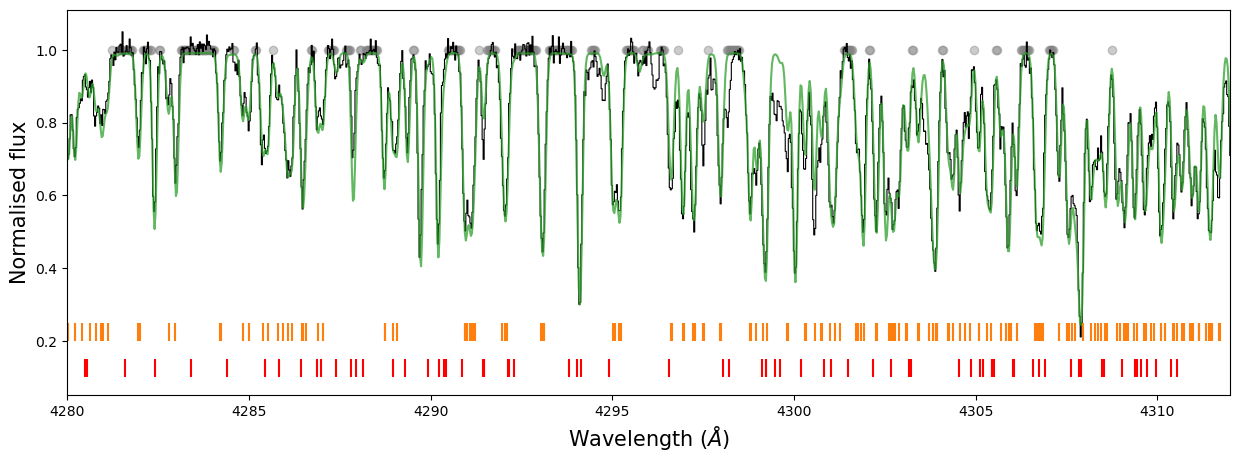

In [32]:
plt.figure(figsize=(15,5))

plt.step(sme.wave.data, sme.spec.data, lw=0.8, color='k')
plt.plot(sme.wave.data, sme.synth.data, lw=1.5, color='C2', alpha=0.75)

plt.scatter(sme.wave.data[sme.mask.data == 2], sme.mask.data[sme.mask.data == 2]-1, color='grey', alpha=0.4)
# plt.scatter(sme.wave.data, sme.mask.data, color='grey', alpha=0.4)

for wline, species, depth in linelist_short_all[['wlcent', 'species', 'depth']]:
    # if 'H 1' in species:
    #     continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
    if (species == 'CN 1'):
        plt.vlines(wline, 0.05, 0.15, color='b')
    if species not in elems_to_include:
        continue
#     # if (depth > 0.85) | (depth < 0.15):
#     #     continue
    plt.vlines(wline, 0.2, 0.25, color='C1')
    # plt.annotate(text='%s' %species, xy=(wline, 0.05), rotation=90)

# plt.hlines(1.02, 4250, 4300)

# plt.ylim(0, 1.1)
# plt.xlim(5165.5, 5185) #Mg
# plt.xlim(4213, 4219) #Sr
# plt.xlim(4074, 4080) #Sr
# plt.xlim(4930, 4938) #Ba
# plt.xlim(4882, 4885) #Y

# plt.xlim(4250, 4350)
# plt.xlim(4280, 4327)

plt.xlim(4280, 4312)
# plt.xlim(3790, 3885)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)
# plt.xlim(6500, 6600)
plt.savefig('plots/CEMP2.pdf')
plt.show()

In [21]:
sme.cscale, sme.fitresults.uncertainties

(array([[0.97984875]]), array([0.6454197]))

In [20]:
#Carbon continuum regions

In [59]:
sme = SME_Structure.load('sme_save/UVES_atm_2541284393302759296_3708442_129.sme')

[2024-11-01 11:08:58,482] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2541284393302759296_3708442_129.sme


INFO - Loading SME file sme_save/UVES_atm_2541284393302759296_3708442_129.sme


In [28]:
cont_blue = ispec.read_continuum_regions('continuum_model/continuum_regions_blue.txt')

In [29]:
# %%time

cont_mask_blue = np.zeros_like(sme.wave[0])

for mask_i, wl in enumerate(sme.wave.data/10.):
    for cont_low, cont_high in cont_blue:
        if (wl <= cont_low) | (wl >= cont_high):
            continue
        else:
            cont_mask_blue[mask_i] = 2
            break

KeyboardInterrupt: 

In [77]:
np.savetxt('continuum_model/sme_cont_mask_blue_carbon', cont_mask_blue, fmt='%d')

In [ ]:
    # # For marcs2012 atmosphere
    # _default_grids = {
    #     "Al": "nlte_Al_ama51_pysme.grd",
    #     "Fe": "marcs2012_Fe2016.grd",
    #     "Li": "nlte_Li_ama51_pysme.grd",
    #     "Mg": "nlte_Mg_ama51_pysme.grd",
    #     "Na": "nlte_Na_ama51_pysme.grd",
    #     "O": "nlte_O_ama51_pysme.grd",
    #     "Ba": "nlte_Ba_ama51_pysme.grd",
    #     "Ca": "nlte_Ca_ama51_pysme.grd",
    #     "Si": "nlte_Si_ama51_pysme.grd",
    #     "Ti": "marcs2012s_t2.0_Ti.grd",
    #     "C": "nlte_C_ama51_pysme.grd",
    #     "H": "nlte_H_ama51_pysme.grd",
    #     "K": "nlte_K_ama51_pysme.grd",
    #     "Mn": "nlte_Mn_ama51_pysme.grd",
    #     "N": "nlte_N_ama51_pysme.grd",
    # }